In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d jessicali9530/celeba-dataset

 98% 1.31G/1.33G [00:39<00:01, 24.9MB/s]
100% 1.33G/1.33G [00:40<00:00, 35.7MB/s]


In [ ]:
! unzip -o celeba-dataset.zip

In [ ]:
! mkdir models
! ls

mkdir: cannot create directory ‘models’: File exists
celeba-dataset.zip  list_attr_celeba.csv     list_landmarks_align_celeba.csv
img_align_celeba    list_bbox_celeba.csv     models
kaggle.json	    list_eval_partition.csv  sample_data


In [ ]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset
import os

In [ ]:
PATH = "./img_align_celeba/img_align_celeba"
img_list = os.listdir(PATH)

In [ ]:
import cv2

class LoadImages(Dataset):
    def __init__(self, transforms=None, limit=20000):
        self.names = img_list[:limit]
        self.PATH = PATH
        self.transforms = transforms
        
        self.samples = [()] * len(self.names)
    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(self.PATH, self.names[idx]), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (150, 150))
        img = img / 255.0
        
        if self.transforms:
            img = self.transforms(img)
        
        self.samples[idx] = img
        return self.samples[idx]

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])
images = LoadImages(transform)

In [ ]:
image_loader = torch.utils.data.DataLoader(images, batch_size=8, shuffle=True)

In [ ]:
def plot_image(images):
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(images):
        plt.subplot(8, 4, i+1)
        plt.imshow(img.squeeze(), cmap="gray")
        plt.axis("off")
    plt.show()

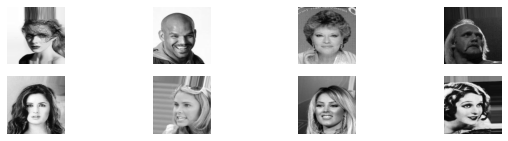

In [ ]:
plot_image(next(iter(image_loader)))

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            # mx150x150x1
            nn.Conv2d(1, 16, 4, 2, 0),
            nn.ReLU(),
            # mx74x74x16
            nn.Conv2d(16, 16, 4, 2, 0),
            nn.ReLU(),
            # mx36x36x16
            nn.Conv2d(16, 32, 4, 2, 0),
            # mx17x17x32
            nn.Conv2d(32, 8, 3, 2, 0)
            # mx8x8x8
        )
        
        self.mean = nn.Linear(8*8*8, 40)
        self.std = nn.Linear(8*8*8, 40)
        
        self.convertor = nn.Linear(40, 8*8*8)
        
        self.decoder = nn.Sequential(
            # mx8x8x8
            nn.ConvTranspose2d(8, 32, 3, 2, 0),
            nn.LeakyReLU(0.2),
            # mx17x17x16
            nn.ConvTranspose2d(32, 16, 4, 2, 0),
            nn.LeakyReLU(0.1),
            # mx36x36x16
            nn.ConvTranspose2d(16, 16, 4, 2, 0),
            nn.LeakyReLU(0.2),
            # mx74x74x16
            nn.ConvTranspose2d(16, 1, 4, 2, 0)
            # mx150x150x1
        )
        
    def encode(self, x):
        encoded = F.relu(self.encoder(x))#.view(-1, 8*8*8)
        encoded = encoded.view(-1, 8*8*8)
        return self.mean(encoded), self.std(encoded)
    
    def reparametrize(self, mean, logvar):
        std = torch.exp(0.5*logvar)
        z = torch.randn_like(std)
        return mean + z*std
    
    def decode(self, x):
        decoded = F.relu(self.convertor(x)).view(-1, 8, 8, 8)
        return F.sigmoid(self.decoder(decoded))
    
    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparametrize(mean, logvar)
        decoded = self.decode(z)
        return decoded, mean, logvar

In [ ]:
from torchvision.utils import make_grid
from tqdm.notebook import tqdm

In [ ]:
print(f"Training Data Size: {len(image_loader)}")

Training Data Size: 2500


In [ ]:
cuda = torch.cuda.is_available()
if cuda:
    print("Cuda")
else:
    print("CPU")

Cuda


In [ ]:
model = VAE()
if cuda:
    model = model.cuda()
print_model_architecture = lambda model: f'\nModel Architecture' + '='*32 + '\n' + f'{model}\n' + '='*32 + '\n'
print(print_model_architecture(model))


Model Architecture================================
VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
    (5): Conv2d(32, 8, kernel_size=(3, 3), stride=(2, 2))
  )
  (mean): Linear(in_features=512, out_features=40, bias=True)
  (std): Linear(in_features=512, out_features=40, bias=True)
  (convertor): Linear(in_features=40, out_features=512, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.2)
    (2): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2))
    (3): LeakyReLU(negative_slope=0.1)
    (4): ConvTranspose2d(16, 16, kernel_size=(4, 4), stride=(2, 2))
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)



In [ ]:
from matplotlib import pyplot as plt

def loss_function(reconstructed_x, x, mean, logvar):
    BCE = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

    return BCE + KLD

def plot_img(image, epoch, cmap='gray'):
    plt.imshow(image.permute(1, 2, 0), cmap=cmap)
    plt.axis('off')
    plt.title(f'Generated Image after {epoch} epochs')
    plt.show()

In [ ]:
def train(model, train_loader, EPOCHS):
    print('Model Training...')
    model.train()
    training_loss = []

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    version = 1
    
    for epoch in range(1, EPOCHS+1):
        train_loss = 0.0
        # progress_bar = tqdm(train_loader, desc="Epoch {:1d}".format(epoch), leave=False, disable=False)

        for i, data in enumerate(train_loader):

            optimizer.zero_grad()

            if cuda:
                data = data.cuda()

            out, mean, std = model(data.float())
            loss = loss_function(out, data.float(), mean, std)
            loss.backward()
            
            # progress_bar.set_postfix({"training_loss": "{:.4f}".format(loss.item()/len(data))})

            train_loss += loss.item()

            optimizer.step()

            if i % 200 == 199:
                print(f'Epoch {epoch+1}, Batch [{i+1}/{len(train_loader)}], Training Loss {loss.item()/i+1}')

        average_train_loss = train_loss / len(train_loader)
        print(f'Training Set Loss {epoch+1}: {round(average_train_loss, 4)}')
        training_loss.append(average_train_loss)

        if epoch % 5 == 0:
            if os.path.exists("/models"):
                os.mkdir("/models")
            torch.save(model.state_dict(), f"./models/face_generatorE{epoch+1}v{version}.pt")
            version += 1

            model.eval()
            with torch.no_grad():
                z = torch.randn(8, 40)
                if cuda:
                    z = z.cuda()
                output_img = model.decode(z).cpu()
                print(output_img.shape)

                grid_img = make_grid(output_img, nrow=4)
                plot_img(grid_img, epoch, cmap='gray')
            model.train()
    return model, training_loss

Model Training...


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 2, Batch [200/2500], Training Loss 486.2013190954774
Epoch 2, Batch [400/2500], Training Loss 246.67013236215539
Epoch 2, Batch [600/2500], Training Loss 168.14693760434056
Epoch 2, Batch [800/2500], Training Loss 136.24932532853566
Epoch 2, Batch [1000/2500], Training Loss 89.61919732232232
Epoch 2, Batch [1200/2500], Training Loss 77.76921523144287
Epoch 2, Batch [1400/2500], Training Loss 72.88306379556826
Epoch 2, Batch [1600/2500], Training Loss 57.65344062695435
Epoch 2, Batch [1800/2500], Training Loss 54.91275535019455
Epoch 2, Batch [2000/2500], Training Loss 46.7031289082041
Epoch 2, Batch [2200/2500], Training Loss 47.97409333788085
Epoch 2, Batch [2400/2500], Training Loss 37.38537216027512
Training Set Loss 2: 98099.7089
Epoch 3, Batch [200/2500], Training Loss 503.3990656407035
Epoch 3, Batch [400/2500], Training Loss 228.82283834586465
Epoch 3, Batch [600/2500], Training Loss 163.45521181135226
Epoch 3, Batch [800/2500], Training Loss 120.477100281602
Epoch 3, Batc

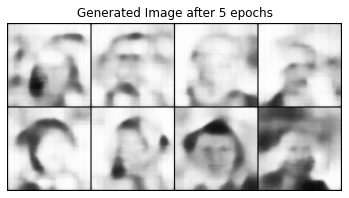

Epoch 7, Batch [200/2500], Training Loss 491.9106862437186
Epoch 7, Batch [400/2500], Training Loss 226.91913377192984
Epoch 7, Batch [600/2500], Training Loss 164.45112948664442
Epoch 7, Batch [800/2500], Training Loss 121.09133487171464
Epoch 7, Batch [1000/2500], Training Loss 99.76916760510511
Epoch 7, Batch [1200/2500], Training Loss 73.9023535237698
Epoch 7, Batch [1400/2500], Training Loss 75.51802068441744
Epoch 7, Batch [1600/2500], Training Loss 62.41253322388993
Epoch 7, Batch [1800/2500], Training Loss 57.40474742912729
Epoch 7, Batch [2000/2500], Training Loss 49.37143571785893
Epoch 7, Batch [2200/2500], Training Loss 48.47396543883583
Epoch 7, Batch [2400/2500], Training Loss 43.04999804606086
Training Set Loss 7: 95383.4937
Epoch 8, Batch [200/2500], Training Loss 431.15369817839195
Epoch 8, Batch [400/2500], Training Loss 263.65728775062655
Epoch 8, Batch [600/2500], Training Loss 163.26938126043405
Epoch 8, Batch [800/2500], Training Loss 105.95215699311639
Epoch 8, B

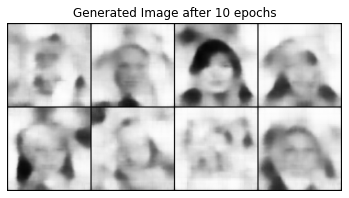

Epoch 12, Batch [200/2500], Training Loss 475.01154208542715
Epoch 12, Batch [400/2500], Training Loss 250.40113956766916
Epoch 12, Batch [600/2500], Training Loss 161.92869626460768
Epoch 12, Batch [800/2500], Training Loss 125.18807689299123
Epoch 12, Batch [1000/2500], Training Loss 102.11537318568568
Epoch 12, Batch [1200/2500], Training Loss 80.45588771893244
Epoch 12, Batch [1400/2500], Training Loss 71.5321044049321
Epoch 12, Batch [1600/2500], Training Loss 58.607884810819264
Epoch 12, Batch [1800/2500], Training Loss 56.22773502640356
Epoch 12, Batch [2000/2500], Training Loss 48.71490041895948
Epoch 12, Batch [2200/2500], Training Loss 42.302410186448384
Epoch 12, Batch [2400/2500], Training Loss 39.65285014589412
Training Set Loss 12: 95150.8002
Epoch 13, Batch [200/2500], Training Loss 500.5897456030151
Epoch 13, Batch [400/2500], Training Loss 252.12386434837092
Epoch 13, Batch [600/2500], Training Loss 155.98215776293824
Epoch 13, Batch [800/2500], Training Loss 113.88683

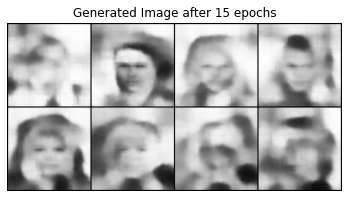

Epoch 17, Batch [200/2500], Training Loss 496.1865970477387
Epoch 17, Batch [400/2500], Training Loss 235.97689536340852
Epoch 17, Batch [600/2500], Training Loss 160.93913032136894
Epoch 17, Batch [800/2500], Training Loss 122.95967615769712
Epoch 17, Batch [1000/2500], Training Loss 87.06243743743744
Epoch 17, Batch [1200/2500], Training Loss 78.84720991451209
Epoch 17, Batch [1400/2500], Training Loss 66.36396533238027
Epoch 17, Batch [1600/2500], Training Loss 55.61564356629143
Epoch 17, Batch [1800/2500], Training Loss 55.40021366036687
Epoch 17, Batch [2000/2500], Training Loss 53.09806074912456
Epoch 17, Batch [2200/2500], Training Loss 45.04036635970896
Epoch 17, Batch [2400/2500], Training Loss 40.12217004481034
Training Set Loss 17: 95046.0083
Epoch 18, Batch [200/2500], Training Loss 486.31921325376885
Epoch 18, Batch [400/2500], Training Loss 238.64475642230576
Epoch 18, Batch [600/2500], Training Loss 155.25558222036727
Epoch 18, Batch [800/2500], Training Loss 114.6643265

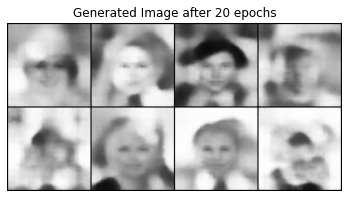

Epoch 22, Batch [200/2500], Training Loss 464.51099246231155
Epoch 22, Batch [400/2500], Training Loss 235.0888941102757
Epoch 22, Batch [600/2500], Training Loss 156.73616183222038
Epoch 22, Batch [800/2500], Training Loss 114.84908870463079
Epoch 22, Batch [1000/2500], Training Loss 100.77999874874875
Epoch 22, Batch [1200/2500], Training Loss 77.63514517306088
Epoch 22, Batch [1400/2500], Training Loss 72.21758845604003
Epoch 22, Batch [1600/2500], Training Loss 58.98810291588493
Epoch 22, Batch [1800/2500], Training Loss 48.546557983602
Epoch 22, Batch [2000/2500], Training Loss 47.80437484367184
Epoch 22, Batch [2200/2500], Training Loss 47.015795532060025
Epoch 22, Batch [2400/2500], Training Loss 41.96599820237599
Training Set Loss 22: 94979.6682
Epoch 23, Batch [200/2500], Training Loss 534.3361730527638
Epoch 23, Batch [400/2500], Training Loss 224.7332001879699
Epoch 23, Batch [600/2500], Training Loss 161.44642111853088
Epoch 23, Batch [800/2500], Training Loss 119.119250625

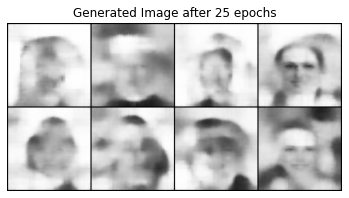

Epoch 27, Batch [200/2500], Training Loss 472.3144629396985
Epoch 27, Batch [400/2500], Training Loss 242.10422540726816
Epoch 27, Batch [600/2500], Training Loss 168.44512990400668
Epoch 27, Batch [800/2500], Training Loss 114.67318523153942
Epoch 27, Batch [1000/2500], Training Loss 81.67235203953953
Epoch 27, Batch [1200/2500], Training Loss 75.62954806088408
Epoch 27, Batch [1400/2500], Training Loss 67.8600116154396
Epoch 27, Batch [1600/2500], Training Loss 54.53378576454034
Epoch 27, Batch [1800/2500], Training Loss 59.103464598387994
Epoch 27, Batch [2000/2500], Training Loss 49.829188031515756
Epoch 27, Batch [2200/2500], Training Loss 41.497854138244655
Epoch 27, Batch [2400/2500], Training Loss 43.4269552417674
Training Set Loss 27: 94932.0597
Epoch 28, Batch [200/2500], Training Loss 509.89576790201005
Epoch 28, Batch [400/2500], Training Loss 239.73893718671678
Epoch 28, Batch [600/2500], Training Loss 166.896011581803
Epoch 28, Batch [800/2500], Training Loss 107.64782149

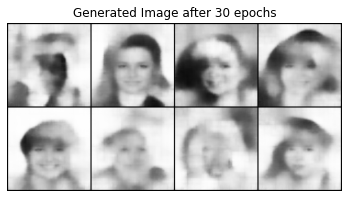

Epoch 32, Batch [200/2500], Training Loss 480.85580244974875
Epoch 32, Batch [400/2500], Training Loss 241.45995848997492
Epoch 32, Batch [600/2500], Training Loss 154.6074316569282
Epoch 32, Batch [800/2500], Training Loss 119.29364831038798
Epoch 32, Batch [1000/2500], Training Loss 95.46412037037037
Epoch 32, Batch [1200/2500], Training Loss 81.21639126355296
Epoch 32, Batch [1400/2500], Training Loss 75.53090935489635
Epoch 32, Batch [1600/2500], Training Loss 57.91075476860538
Epoch 32, Batch [1800/2500], Training Loss 56.769902550027794
Epoch 32, Batch [2000/2500], Training Loss 47.354829758629315
Epoch 32, Batch [2200/2500], Training Loss 45.64949977262392
Epoch 32, Batch [2400/2500], Training Loss 42.39182992913714
Training Set Loss 32: 94898.8583
Epoch 33, Batch [200/2500], Training Loss 496.11063128140705
Epoch 33, Batch [400/2500], Training Loss 211.26492011278197
Epoch 33, Batch [600/2500], Training Loss 160.04943134390652
Epoch 33, Batch [800/2500], Training Loss 128.89002

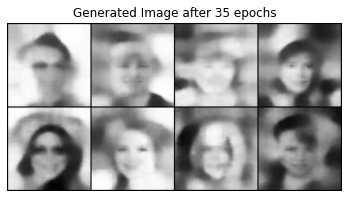

Epoch 37, Batch [200/2500], Training Loss 479.81257851758795
Epoch 37, Batch [400/2500], Training Loss 236.7594572368421
Epoch 37, Batch [600/2500], Training Loss 157.71165484140235
Epoch 37, Batch [800/2500], Training Loss 123.94183158635795
Epoch 37, Batch [1000/2500], Training Loss 103.32682682682683
Epoch 37, Batch [1200/2500], Training Loss 75.4179589762302
Epoch 37, Batch [1400/2500], Training Loss 69.14422690314511
Epoch 37, Batch [1600/2500], Training Loss 62.916393058161354
Epoch 37, Batch [1800/2500], Training Loss 57.94413128821567
Epoch 37, Batch [2000/2500], Training Loss 50.57320066283142
Epoch 37, Batch [2200/2500], Training Loss 40.00455462710323
Epoch 37, Batch [2400/2500], Training Loss 41.32749973947478
Training Set Loss 37: 94878.6481
Epoch 38, Batch [200/2500], Training Loss 493.3961997487437
Epoch 38, Batch [400/2500], Training Loss 225.01125861528823
Epoch 38, Batch [600/2500], Training Loss 165.01582063856426
Epoch 38, Batch [800/2500], Training Loss 127.0220001

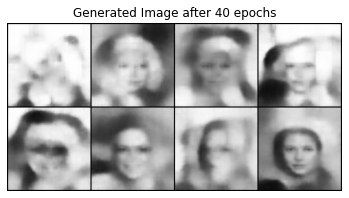

Epoch 42, Batch [200/2500], Training Loss 493.0993640075377
Epoch 42, Batch [400/2500], Training Loss 228.73026315789474
Epoch 42, Batch [600/2500], Training Loss 153.30240505008348
Epoch 42, Batch [800/2500], Training Loss 113.74157149561952
Epoch 42, Batch [1000/2500], Training Loss 90.07854729729729
Epoch 42, Batch [1200/2500], Training Loss 78.93434633027523
Epoch 42, Batch [1400/2500], Training Loss 71.12935020550393
Epoch 42, Batch [1600/2500], Training Loss 62.472258051907446
Epoch 42, Batch [1800/2500], Training Loss 49.909454905503054
Epoch 42, Batch [2000/2500], Training Loss 50.46382566283142
Epoch 42, Batch [2200/2500], Training Loss 41.48847487494316
Epoch 42, Batch [2400/2500], Training Loss 39.6545533295123
Training Set Loss 42: 94871.212
Epoch 43, Batch [200/2500], Training Loss 497.5018059045226
Epoch 43, Batch [400/2500], Training Loss 232.54583724937342
Epoch 43, Batch [600/2500], Training Loss 161.03928422370618
Epoch 43, Batch [800/2500], Training Loss 123.76705256

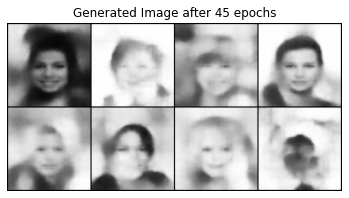

Epoch 47, Batch [200/2500], Training Loss 490.4766802763819
Epoch 47, Batch [400/2500], Training Loss 235.9454495614035
Epoch 47, Batch [600/2500], Training Loss 170.92621817612687
Epoch 47, Batch [800/2500], Training Loss 118.74793687421777
Epoch 47, Batch [1000/2500], Training Loss 97.45184246746747
Epoch 47, Batch [1200/2500], Training Loss 69.93824280650541
Epoch 47, Batch [1400/2500], Training Loss 72.25332268584704
Epoch 47, Batch [1600/2500], Training Loss 59.52529901500938
Epoch 47, Batch [1800/2500], Training Loss 51.4269689758199
Epoch 47, Batch [2000/2500], Training Loss 51.14903545522761
Epoch 47, Batch [2200/2500], Training Loss 44.35117525011369
Epoch 47, Batch [2400/2500], Training Loss 35.833029387244686
Training Set Loss 47: 94848.8162
Epoch 48, Batch [200/2500], Training Loss 420.99187342964825
Epoch 48, Batch [400/2500], Training Loss 249.54321350250626
Epoch 48, Batch [600/2500], Training Loss 160.10917936143574
Epoch 48, Batch [800/2500], Training Loss 117.20519790

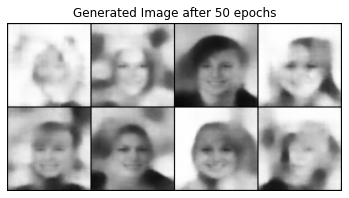

In [ ]:
model, training_loss = train(model, image_loader, 50)